In [205]:
import h5py as h5
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.python.ops.resource_variable_ops import ResourceVariable
from tensorflow import keras
from modules.loaders import LoadDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [206]:
###* Load the dataset
dataset = LoadDataset(h5_file= 'positions_FACES_GERARDO.h5').load_h5()
type(dataset)

h5py._hl.files.File

In [207]:
with dataset as h5file:
    data_h5 = []
    labels = []
    for face in h5file.keys():
        positions = h5file[face]['positions'][:]
        data_h5.append(positions)
        # print(positions.shape)
        labels.extend([face]*positions.shape[1]) #* extend is used to add the elements of the list, not the list itself  

labels = np.array(labels)
labels_letter = np.reshape(labels, (labels.shape[0], ))
labels_letter.shape


(12000,)

In [208]:
for i, id in enumerate(data_h5):
    print('Data shape',i, id.shape)

Data shape 0 (1872, 3000)
Data shape 1 (1872, 3000)
Data shape 2 (1872, 3000)
Data shape 3 (1872, 3000)


#### Remember nx -> 468*2 (positions in x and y)     m -> number of samples

In [209]:
label_encoder = LabelEncoder() ###* Face TO NUMBERS 
labels = label_encoder.fit_transform(labels_letter)
print('The number of classes is:', len(label_encoder.classes_))
labels.shape

The number of classes is: 4


(12000,)

In [210]:
label_encoder.classes_

array(['FELIZ', 'NEUTRAL', 'SORPRESA', 'TRISTE'], dtype='<U8')

### For every sample m we have one label

In [211]:
data = np.concatenate(data_h5,axis=1)
data.shape

(1872, 12000)

#### sklearn needs data.shape = (m, nx), where:
#### m is the number of samples
#### nx number of featues (positions in this case)

In [212]:
data = data.T
data.shape


(12000, 1872)

In [213]:
data[0,:]

array([362, 356, 360, ...,   0,   0,   0])

In [214]:
X_train, X, y_train, Y = train_test_split(data, labels, test_size=0.3)

In [215]:
X_train.shape, y_train.shape, X.shape, Y.shape

((8400, 1872), (8400,), (3600, 1872), (3600,))

#### Now we have our train dataset but we need a dev and test dataset

In [216]:
X_dev, X_test, y_dev, y_test = train_test_split(X, Y, test_size=0.5, )

In [217]:
m = X_train.shape[0] # number of samples
print(f'Traininig set: {X_train.shape[0]} samples')
print(f'Dev set: {X_dev.shape[0]} samples')
print(f'Test set: {X_test.shape[0]} samples')

Traininig set: 8400 samples
Dev set: 1800 samples
Test set: 1800 samples


##### We have 60% for training and 20% for dev,test data
##### Now we need to normalize the data, let's to use the z-score method

In [218]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) #* Normalize X_train using the mean and standard deviation of the training set
X_dev = scaler.transform(X_dev)  #* Normalize X_test using the mean and standard deviation of the training set
X_test = scaler.transform(X_test)  #* Normalize X_test using the mean and standard deviation of the training set

### ONE HOT to create our matrix with labels

In [219]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
y_dev_onehot = encoder.transform(y_dev.reshape(-1, 1))
y_test_onehot = encoder.transform(y_test.reshape(-1, 1))
y_train_onehot.shape, y_dev_onehot.shape, y_test_onehot.shape

((8400, 4), (1800, 4), (1800, 4))

In [220]:
y_train_onehot[0]

array([0., 0., 1., 0.])

In [221]:
# Convertir el array a una serie de pandas
import pandas as pd
y_dev_series = pd.Series(y_dev)

# Contar la frecuencia de cada elemento
element_counts = y_dev_series.value_counts()
print(element_counts)

0    467
1    450
3    446
2    437
Name: count, dtype: int64


#### Let's to build our first NEURAL NETWORK

Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - categorical_accuracy: 0.2797 - loss: 22.3242 - val_categorical_accuracy: 0.3478 - val_loss: 6.0318
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - categorical_accuracy: 0.3718 - loss: 4.6617 - val_categorical_accuracy: 0.3539 - val_loss: 2.4929
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - categorical_accuracy: 0.4102 - loss: 2.1380 - val_categorical_accuracy: 0.4272 - val_loss: 1.6742
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - categorical_accuracy: 0.4335 - loss: 1.5514 - val_categorical_accuracy: 0.4483 - val_loss: 1.3907
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - categorical_accuracy: 0.4929 - loss: 1.2975 - val_categorical_accuracy: 0.4844 - val_loss: 1.3109
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - categorical_accuracy: 0.5278 - loss: 1.1792 - val_categorical_accuracy: 0.4667 - val_loss: 1.2736
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - categorical_accuracy: 0.5353 - lo

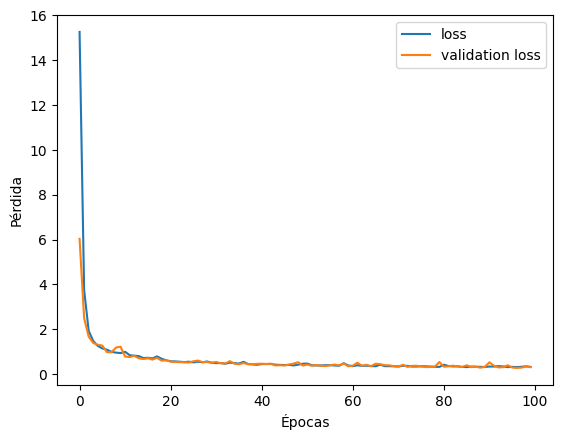

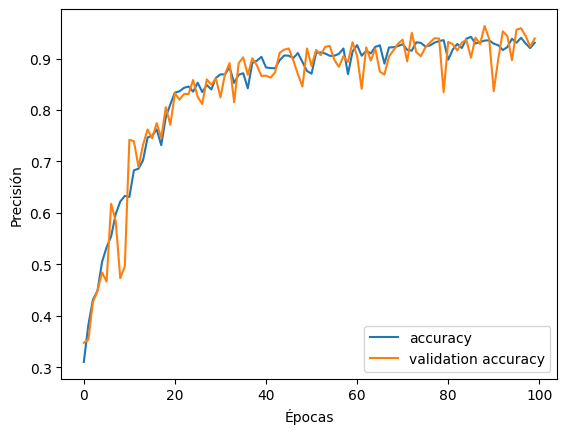

In [222]:
from tensorflow.keras.optimizers import Adam
num_classes = y_train_onehot.shape[1]  # Número de clases

model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(shape=(1872,)),
    tf.keras.layers.Dense(1056, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    # tf.keras.layers.Dropout(0.5),  # Dropout con 50% de probabilidad
    tf.keras.layers.Dense(1056, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Regularización L2
    # tf.keras.layers.Dropout(0.5),  # Otro Dropout con 50% de probabilidad
    # tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Regularización L2
    # tf.keras.layers.Dropout(0.5),  # Otro Dropout con 50% de probabilidad
    # tf.keras.layers.Dense(528, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Regularización L2
    # tf.keras.layers.Dropout(0.5),  # Otro Dropout con 50% de probabilidad
    tf.keras.layers.Dense(528, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Regularización L2
    # tf.keras.layers.Dense(264, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Regularización L2
    # tf.keras.layers.Dense(1056, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Regularización L2
    
    
    # tf.keras.layers.Dense(264, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Regularización L2
    # tf.keras.layers.Dense(264, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Regularización L2
    # tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Regularización L2
    # tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Regularización L2
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
# Compilar el modelo
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Entrenar el modelo
history = model.fit(X_train, y_train_onehot,
                    epochs=100,
                    batch_size=128,
                    validation_data=(X_dev, y_dev_onehot))
                    # callbacks=[early_stopping])

# Opcional: Graficar la pérdida y la precisión durante el entrenamiento
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


plt.plot(history.history['categorical_accuracy'], label='accuracy') 
plt.plot(history.history['val_categorical_accuracy'], label='validation accuracy')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

In [223]:
c_acuracy = history.history['categorical_accuracy'][0::30]
v_acuracy = history.history['val_categorical_accuracy'][0::30]
epocas = np.arange(1, len(history.history['categorical_accuracy']) + 1, 30)


Text(0, 0.5, 'Precisión')

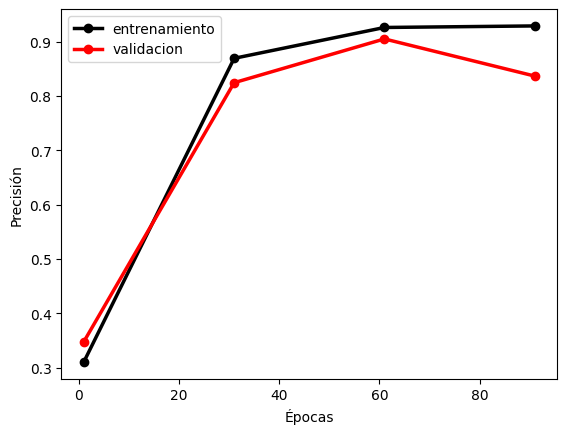

In [224]:
plt.plot(epocas,c_acuracy, label='entrenamiento', color='black', linewidth=2.5, linestyle='-', marker='o')
plt.plot(epocas,v_acuracy, label='validacion', color='red', linewidth=2.5, linestyle='-', marker='o')
plt.legend()

plt.xlabel('Épocas')
plt.ylabel('Precisión')
# plt.savefig('C:\\Users\\hgera\\OneDrive\\Escritorio\\PY4E\\figuras\\accuracy_faces.pdf')


### Confusion matrix

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[1.         1.         0.9999999  1.         0.9999999  0.99999994
 1.         1.         1.         1.        ]
[1 2 1 ... 0 2 2]


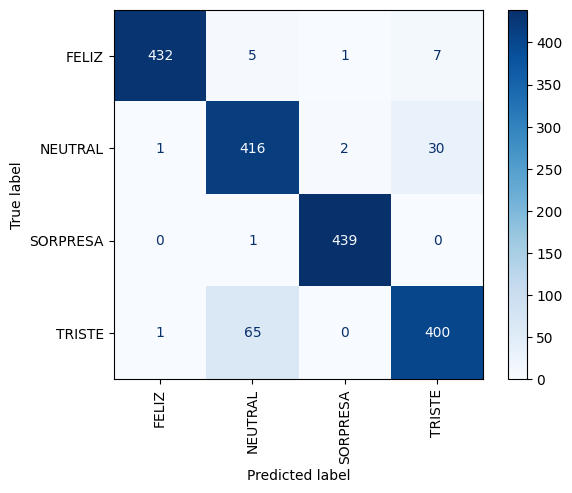

Categorical Accuracy: 0.9372
Accuracy per class: [0.97078652 0.92650334 0.99772727 0.8583691 ]


In [225]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
print(np.sum(y_pred[0:10],axis=1))
y_pred = np.argmax(y_pred, axis=1) ### Predictions
print(y_pred)
y_true_class = np.argmax(y_test_onehot, axis=1) ### True values

cm = confusion_matrix(y_true_class, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.show()

# Sumar los valores diagonales (predicciones correctas)
correct_predictions = np.trace(cm)

# Sumar todos los valores de la matriz (total de predicciones)
total_predictions = np.sum(cm)

# Calcular la categorical accuracy
categorical_accuracy = correct_predictions / total_predictions

print(f'Categorical Accuracy: {categorical_accuracy:.4f}')

accuracy_per_class = cm.diagonal() / cm.sum(axis=1)
print("Accuracy per class:", accuracy_per_class)

##### 0.72 of correct predictions of the total of data
##### angry: 0.56
##### happy: 0.87
##### neutral: 0.94
##### surprise: 0.71
##### sad: 0.49

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Clase 0: Best treshold = 0.1799694299697876
Clase 1: Best treshold = 0.6029543876647949
Clase 2: Best treshold = 0.6165906190872192
Clase 3: Best treshold = 0.31580111384391785


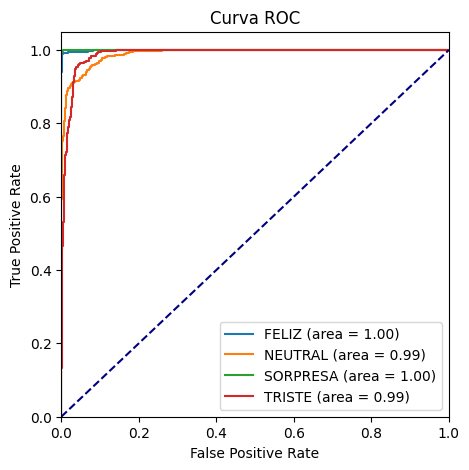

Optimized Tresholds per class  [0.17996943 0.60295439 0.61659062 0.31580111]


In [226]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
y_pred = model.predict(X_test)
num_classes = y_train_onehot.shape[1]
best_thresholds = np.zeros(num_classes)

plt.figure(figsize=(5, 5))

#### Calculate ROC curve and ROC area for each class
for i in range(num_classes):
    y_true_binary = (y_true_class == i).astype(int)
    # print(y_true_binary)
    #### Compute ROC curve and ROC area
    fpr, tpr, threshold = roc_curve(y_true_binary, y_pred[:,i])
    #### Calcualte Youden's J statistic
    J = tpr - fpr
    best_threshold = threshold[np.argmax(J)]
    best_thresholds[i] = best_threshold
    
    print(f'Clase {i}: Best treshold = {best_threshold}')
    
    
    
    ### Calcular el área bajo la curva ROC
    
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label_encoder.classes_[i]} (area = {roc_auc:0.2f})')
    
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()



print('Optimized Tresholds per class ',best_thresholds)

(-0.5, 699.5, 699.5, -0.5)

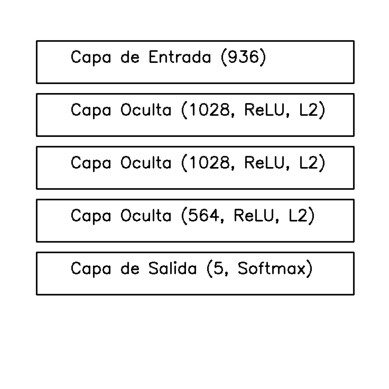

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Parámetros para la red neuronal
input_shape = 936  # Número de neuronas de entrada
num_classes = 5 # Número de neuronas de salida (clases)
hidden_layers = [(1028, 'ReLU', 'L2'), (1028, 'ReLU', 'L2'),(564, 'ReLU', 'L2')]  # Capas ocultas con número de neuronas, activación y regularización

# Crear una imagen en blanco
height, width = 700, 700  # Dimensiones de la imagen
image = np.ones((height, width, 3), dtype=np.uint8) * 255  # Fondo blanco

# Coordenadas iniciales y finales para dibujar las capas
start_x = 50
end_x = width - 50
layer_height = 100  # Altura de cada capa

# Dibujar la capa de entrada
cv2.putText(image, f'    Capa de Entrada ({input_shape})', (start_x, layer_height), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
cv2.rectangle(image, (start_x, layer_height - 40), (end_x, layer_height + 40), (0, 0, 0), 2)

# Dibujar capas ocultas
for i, (neurons, activation, regularization) in enumerate(hidden_layers, start=2):
    cv2.putText(image, f'    Capa Oculta ({neurons}, {activation}, {regularization})', 
                (start_x, i * layer_height), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
    cv2.rectangle(image, (start_x, i * layer_height - 40), (end_x, i * layer_height + 40), (0, 0, 0), 2)

# Dibujar la capa de salida
cv2.putText(image, f'    Capa de Salida ({num_classes}, Softmax)', (start_x, (len(hidden_layers) + 2) * layer_height), 
            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
cv2.rectangle(image, (start_x, (len(hidden_layers) + 2) * layer_height - 40), 
              (end_x, (len(hidden_layers) + 2) * layer_height + 40), (0, 0, 0), 2)

# Mostrar la imagen
# cv2.imshow('Red Neuronal', image)
plt.imshow(image)
plt.axis('off')



In [227]:
# Evaluar el modelo
print('***'*50)

test_loss, test_acc = model.evaluate(X_test, y_test_onehot, verbose=2)
print(f'Acuraccy on test data: {test_acc}')
print(f'Loss on test data: {test_loss}')


******************************************************************************************************************************************************
57/57 - 0s - 8ms/step - categorical_accuracy: 0.9372 - loss: 0.3103
Acuraccy on test data: 0.9372222423553467
Loss on test data: 0.3102886378765106


In [228]:
# * Save the model
path_save = '..\\..\\models\\Trained\\face\\face_model_GERARDO.h5'
model.save(path_save)

### REVISION


In [201]:
model = tf.keras.models.load_model(path_save)
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_37 (Dense)                │ (None, 1056)           │     1,977,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1056)           │     1,116,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 528)            │       558,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 5)              │         2,645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,654,823 (13.94 MB)

 Trainable params: 3,654,821 (13.94 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [203]:
# Supongamos que tienes datos nuevos para predecir
dict_labels = {i: letter for i, letter in enumerate(label_encoder.classes_)}
print(dict_labels.values())
new_data = data_h5[4][:, 1000 ]  # Supongamos que solo tenemos un dato nuevo
new_data = new_data.reshape(1, -1)  # Convertirlo a un arreglo 2D
print(new_data.shape)
# Preprocesar los datos nuevos (normalización, etc.)
new_data_normalized = scaler.transform(new_data)  # Normalización Z-score

# Hacer predicciones
predictions = model.predict(new_data_normalized)

# Convertir las predicciones a etiquetas
predicted_class = np.argmax(predictions, axis=1)

print(f'Predicción: {dict_labels[predicted_class[0]]}')

dict_values(['ENOJO', 'FELIZ', 'NEUTRAL', 'SORPRESA', 'TRISTE'])
(1, 1872)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Predicción: TRISTE


#### SAVE the values of the normalization

In [229]:
from sklearn.preprocessing import StandardScaler
import joblib
import numpy as np


# Guardar el escalador ajustado en un archivo
joblib.dump(scaler, '..\\..\\models\\Trained\\face\\scaler_faces_GERARDO.pkl')


['..\\..\\models\\Trained\\face\\scaler_faces_GERARDO.pkl']